## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob, os
import matplotlib.pyplot as plt
import PyQt5
%matplotlib inline

### Load camera calibration data

In [33]:
img_dir = 'output_images/'

import pickle
if not os.path.exists("./data/cali_pickle.p"):
    print("Run camera_calibraton.ipynb first.")
else:    
    cali_pickle = pickle.load( open( "./data/cali_pickle.p", "rb" ) )
    mtx = cali_pickle['mtx']
    dist = cali_pickle['dist']
    M = cali_pickle['M']
    Minv = cali_pickle['Minv']
    src = cali_pickle['src']
    dst = cali_pickle['dst']

### Gradient Threshold

In [3]:
def mag_thresh(img, sobel_kernel=4, mag_thresh=(0, 255)):
    """sobel magnitude threshold"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary [(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return mag_binary
    
def grad_thresh(img, sobel_kernel=9, dir_thresh=(0, np.pi/2)): 
    """sobel gradient threshold"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel > dir_thresh[0]) & (dir_sobel < dir_thresh[1])] = 1
    return dir_binary    

def s_thresh(img, s_thresh=(170,255)):
    """S channel threshold"""
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

In [4]:
def color_thresh(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # For yellow lane line
    yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    # For white lane line
    sensitivity_1 = 68
    white = cv2.inRange(hsv, (0,0,255-sensitivity_1), (255,20,255))
    sensitivity_2 = 60
    hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    white_2 = cv2.inRange(hsl, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(img, (200,200,200), (255,255,255))
    # color_binary = np.zeros_like(hsv[:,:,0])
    color_binary = (yellow) | (white) | (white_2) | (white_3)
    color_binary[color_binary >= 1] = 1
    return color_binary

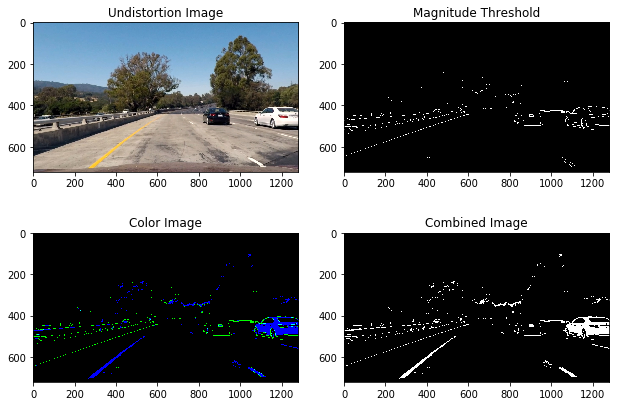

In [65]:
# Read a image
img = cv2.imread('./test_images/test1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Use the OpenCV undistort() function to remove distortion
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

# Compute the magnitude and direction of the gradient
mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(100, 250))
dir_binary = grad_thresh(undistorted, sobel_kernel=11, dir_thresh=(0.7, np.pi/2))
color_binary = color_thresh(undistorted)

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
combined_binary_color = np.dstack(( np.zeros_like(mag_binary), mag_binary, color_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(mag_binary)
combined_binary[(color_binary == 1) | (mag_binary == 1)] = 1

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(undistorted_rgb)
ax1.set_title('Undistortion Image', fontsize=12)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Magnitude Threshold', fontsize=12)
ax3.imshow(combined_binary_color)
ax3.set_title('Color Image', fontsize=12)
ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig(img_dir + "/binary_result.png", dpi=300, bbox_inches='tight')

### Select frame with shadow

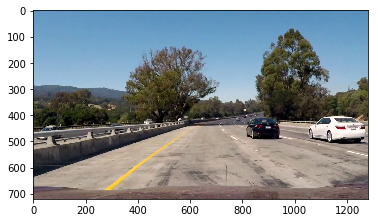

In [30]:
cap = cv2.VideoCapture('project_video.mp4')

time_length = 50.0
fps=25
frame_seq = 41.4
frame_no = fps * frame_seq
cap.set(1,1000);

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)

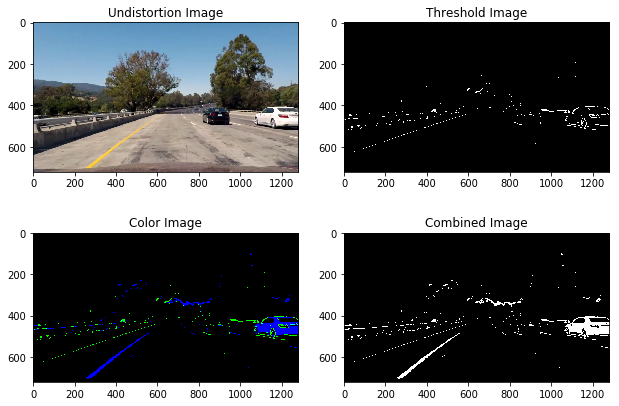

In [31]:
# Use the OpenCV undistort() function to remove distortion
undistorted = cv2.undistort(frame, mtx, dist, None, mtx)
undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)


# Compute the magnitude and direction of the gradient
mag_binary = mag_thresh(undistorted, sobel_kernel=1, mag_thresh=(100, 250))
dir_binary = grad_thresh(undistorted, sobel_kernel=11, dir_thresh=(0.7, np.pi/2))
s_binary = s_thresh(undistorted, s_thresh=(50,250))
color_binary = color_thresh(undistorted)

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
combined_binary_color = np.dstack(( np.zeros_like(mag_binary), mag_binary, color_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(mag_binary)
combined_binary[(color_binary == 1) | (mag_binary == 1)] = 1

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(undistorted_rgb)
ax1.set_title('Undistortion Image', fontsize=12)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Threshold Image', fontsize=12)
ax3.imshow(combined_binary_color)
ax3.set_title('Color Image', fontsize=12)
ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Finding the Lines

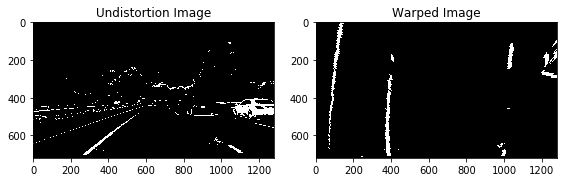

In [66]:
img_size = (undistorted.shape[1], undistorted.shape[0])
warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistortion Image', fontsize=12)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=12)

plt.savefig(img_dir + "/warped.png", dpi=300, bbox_inches='tight')

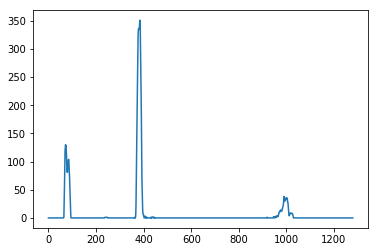

In [67]:
# Calculate histogram of the bottom half of warped image
histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)
plt.savefig(img_dir + "/hostogram.png", dpi=300, bbox_inches='tight')

In [37]:
def find_lines_initial(warped):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    
    # Calculate histogram of the bottom half of warped image
    histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)
    # Choose the left and right starting points
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # sliding windows number
    nwindows = 9
    # sliding windows height
    window_height = np.int(warped.shape[0]/nwindows)

    # Nonzero pixels index in the warped img
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current window position
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of windows margin
    margin = 50
    # Set minimum pixels to recenter window
    minpix = 20
    
    # Left and right lane pixel indices lists
    left_lane_idx = []
    right_lane_idx = []

    for window in range(nwindows):
        # Left and right window boundaries
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = win_y_low + window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw left window
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), 
                      (win_xleft_high, win_y_high), (0,255,0),10)
        # Draw right window
        cv2.rectangle(out_img, (win_xright_low, win_y_low), 
                      (win_xright_high, win_y_high), (0,255,0),10)

        # Identify nonzero pixels in window
        good_left_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append indices into lists
        left_lane_idx.append(good_left_idx)
        right_lane_idx.append(good_right_idx)

        if len(good_left_idx) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idx]))
        if len(good_right_idx) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_idx]))

    # Concatenate indices arrays
    left_lane_idx = np.concatenate(left_lane_idx)
    right_lane_idx = np.concatenate(right_lane_idx)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx] 
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting   
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lines = {}
    lines['ploty'] = ploty
    lines['left_fitx'] = left_fitx
    lines['right_fitx'] = right_fitx
    lines['left_fit'] = left_fit
    lines['right_fit'] = right_fit
    
    out_img[nonzeroy[left_lane_idx], nonzerox[left_lane_idx]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_idx], nonzerox[right_lane_idx]] = [0, 0, 255]  
    
    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, lines

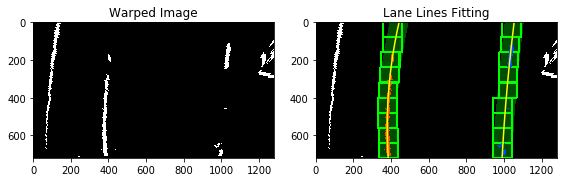

In [68]:
out_img,lines = find_lines_initial(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(warped, cmap='gray')
ax1.set_title('Warped Image', fontsize=12)
ax2.imshow(out_img, cmap='gray')
plt.plot(lines['left_fitx'], lines['ploty'], color='yellow')
plt.plot(lines['right_fitx'], lines['ploty'], color='yellow')
ax2.set_title('Lane Lines Fitting', fontsize=12)

plt.savefig(img_dir + "/line_fitting.png", dpi=300, bbox_inches='tight')

In [39]:
def curvature(lines):
    """Calculate lane curvatures"""
    ploty = lines['ploty']
    left_fitx = lines['left_fitx']
    right_fitx = lines['right_fitx'] 
    left_fit = lines['left_fit']
    right_fit = lines['right_fit'] 
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature (radius of curvature is in meters)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [40]:
def lane_offset(lines):
    """Calculate current vechile position from center of the lane"""
    ploty = lines['ploty']
    left_fitx = lines['left_fitx']
    right_fitx = lines['right_fitx'] 
    left_fit = lines['left_fit']
    right_fit = lines['right_fit'] 
    
    y_max = 720
    midpoint = 1280/2.
    
    xm_per_pix = 3.7/700
    
    x_left = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    x_right = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    position = (x_right-x_left)/2. + x_left - midpoint
    
    # Transfer pixel into meter 
    position = position * xm_per_pix
    
    return position

In [41]:
def draw_lane(img, warped, lines):
    """Draw lane onto the image"""
    ploty = lines['ploty']
    left_fitx = lines['left_fitx']
    right_fitx = lines['right_fitx'] 
    # Create image to draw lines
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y points into usable format for cv2.fillpoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image
    warp_inv = cv2.warpPerspective(color_warp, Minv, img_size)
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, warp_inv, 0.3, 0)
    
    return out_img

In [42]:
# Lines curvatures
left_curv, right_curv = curvature(lines)
print("Left curvature: {:.2f} m".format(left_curv))
print("Right curvature: {:.2f} m".format(right_curv))

Left curvature: 807.99 m
Right curvature: 3337.76 m


In [43]:
# Vechicle offset from the center of lane
offset = lane_offset(lines)
print("Current offset from the center: {:.2f} m".format(offset))

Current offset from the center: 0.25 m


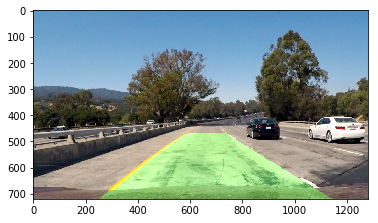

In [69]:
# Draw lane on the origial road
out_img = draw_lane(img_rgb, warped, lines)
plt.imshow(out_img)
plt.savefig(img_dir + "/result.png", dpi=300, bbox_inches='tight')

### Skip sliding windows step once find lines

In [ ]:
def find_lines(warped, lines):
    
    ploty = lines['ploty']
    left_fitx = lines['left_fitx']
    right_fitx = lines['right_fitx'] 
    left_fit = lines['left_fit']
    right_fit = lines['right_fit']
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 50
    # Set minimum pixels to recenter window
    minpix = 20   
    
    left_lane_idx = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_idx = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx]
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_idx], nonzerox[left_lane_idx]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_idx], nonzerox[right_lane_idx]] = [0, 0, 255]
    
    lines = {}
    lines['ploty'] = ploty
    lines['left_fitx'] = left_fitx
    lines['right_fitx'] = right_fitx
    lines['left_fit'] = left_fit
    lines['right_fit'] = right_fit

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0) 
    return out_img, lines

In [ ]:
out_img,lines = find_lines(warped,lines)
plt.imshow(out_img)
plt.plot(lines['left_fitx'], lines['ploty'], color='yellow')
plt.plot(lines['right_fitx'], lines['ploty'], color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)